# Evaluating a CellPose2 model

In this notebook, we will take predictions from our model_training notebook to compare with the ground truth data to showcase how to evaluate how a cell segmenting model performs.

Our data is pictures of cells and masks. The masks each segment multiple cells of the images and give each cell its own color code.

Most of the code, the functions at least, come from the seg_functions.py file.

In [1]:
#Imports and loading directories
import seg_functions
from seg_functions import *
import importlib
importlib.reload(seg_functions)

model_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
train_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training"
test_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_testing"

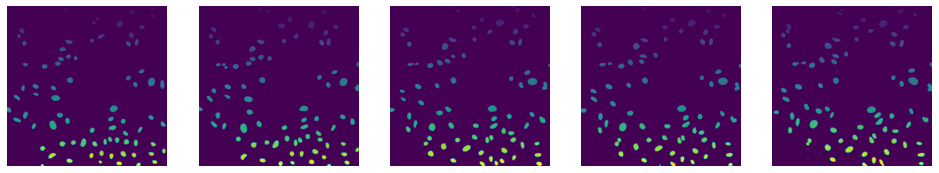

In [3]:
#Making predictions with the images in the test directory and the model we just imported
#Lets calculate the time taken to get the predictions,first of the whole cell

test_data, test_labels = io.load_train_test_data(test_dir, mask_filter='_seg.npy')[:2]  # loads the test data
predictions = make_predictions(model_dir,test_dir)
display_imgs(predictions)

## Qualitative evaluation

This section will be displaying the visual results made by the model, counting the cells and making crops around them to compare between the ground truth mask and the predicted mask..

In [4]:
#Count the cells in a mask
for pred_mask in predictions: print('Number of cells:',count_cells(pred_mask))

Number of cells: 79
Number of cells: 80
Number of cells: 80
Number of cells: 79
Number of cells: 79


### Individually segmenting out the cells

This process follows the following method:
    &nbsp;&nbsp;&nbsp;&nbsp;get the pixel values that are in the predicted mask (0 is the background)
    &nbsp;&nbsp;&nbsp;&nbsp;for each pixel value
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;get its 4 corners
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;calculate its longest diagonal
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;use it to create a bounding box around the cell
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;store the coordinates of that bounding box
    &nbsp;&nbsp;&nbsp;&nbsp;apply all of the bounding boxes around the original image to see if it retrieves the nuclei

In [5]:
#Use the masks to crop around the cells in the original cell image
cell_img1 = test_data[0] #loading the first cell img
crop_coordinates = get_cell_crop_coordinates(predictions[0]) #get the coordinates from the mask
crops = get_img_crops(cell_img1, crop_coordinates) #apply the crops on the real image

display_imgs(crops)

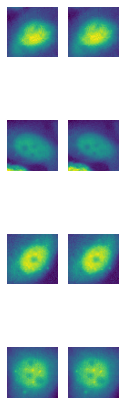

In [12]:
ious = metrics.mask_ious(test_labels[0],predictions[0])
pairs = match_cell_crops(cell_img1,test_labels[0],predictions[0])
display_pairs(pairs,ious,'most_different','only_matched',num=4) #add a limited number as input of number to display

## Quantitative evaluation

This section will be using the metrics function from the CellPose package to evaluate the model's predictions.

In [13]:
#Get the average precision of the model at one threshold
average_precision = get_average_precision(test_labels,predictions)
print('The average precision of the model is:',average_precision)

The average precision of the model is: 0.88018954


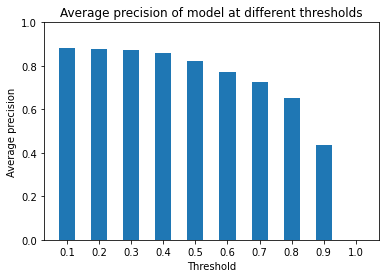

In [14]:
#Get the average precision at different thresholds in a bar plot
display_average_precision(test_labels,predictions)
#should add variation to compare between models

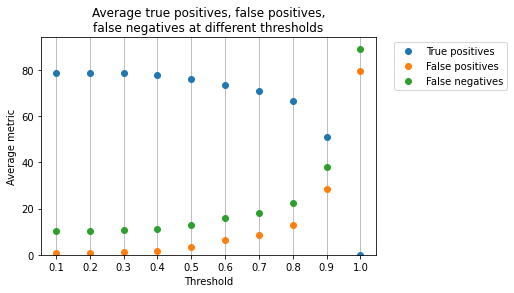

In [15]:
#Get the average TP, FP and FN at different thresholds in a scatter plot
#Can't get confusion matrix because there are no true negatives?
display_average_confusion(test_labels,predictions)

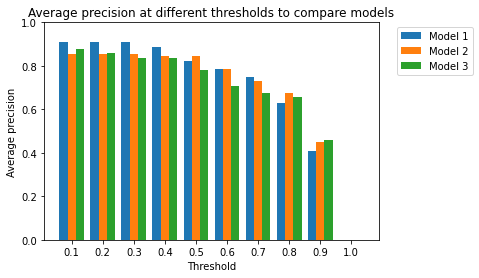

In [17]:
# Function to compare two models in average precision at different thresholds
# Should be able to compare as many models as we want

#Making up test data of multiple models
model1_labels = test_labels[0:2]
model1_pred = predictions[0:2]
model2_labels = test_labels[2:4]
model2_pred = predictions[2:4]
model3_labels = test_labels[4:5]
model3_pred = predictions[4:5]

model_results = [[model1_labels,model1_pred],[model2_labels,model2_pred],[model3_labels,model3_pred]]
display_average_precision_comparison(model_results)

In [91]:
#Get the boundary scores at different scales
scores = get_average_boundary_scores(test_labels,predictions)
print('At scale 0.1: precision={}, recall={}, f1={}'.format(scores[0][0],scores[0][1],scores[0][2]))
print('At scale 0.5: precision={}, recall={}, f1={}'.format(scores[1][0],scores[1][1],scores[1][2]))

At scale 0.1: precision=0.877467202138081, recall=0.8264996257434352, f1=0.8511949163702797
At scale 0.5: precision=0.9747841644560905, recall=0.937050200940674, f1=0.9555223028377146


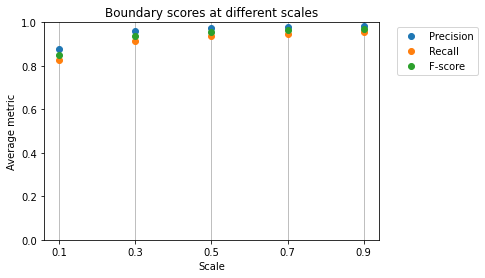

In [92]:
#Display the boundary scores at different scales in a scatter plot
display_average_boundary_scores(test_labels, predictions)

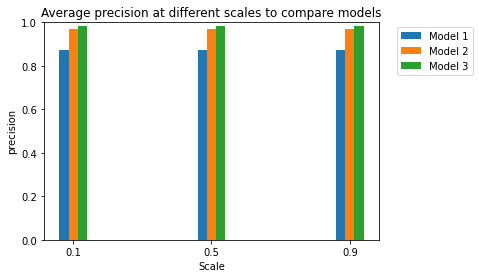

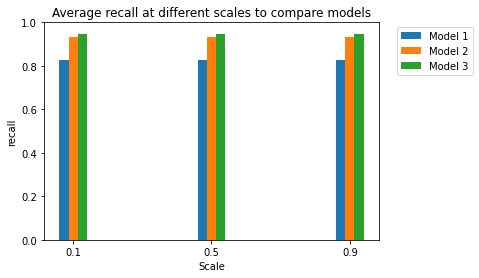

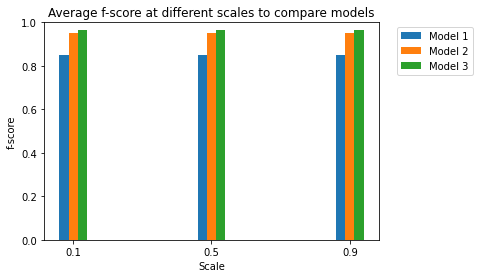

In [143]:
#Compare a boundary score (precision, recall or f1) between different models
#Unexplored bug where it gave an error when inputted with 5 different scales
display_average_boundary_score_comparison(model_results)
display_average_boundary_score_comparison(model_results, boundary_score='recall')
display_average_boundary_score_comparison(model_results, boundary_score='f-score')

In [147]:
# Get the average aggregated jaccard index
get_average_aji(test_labels,predictions)

0.8564155995858685

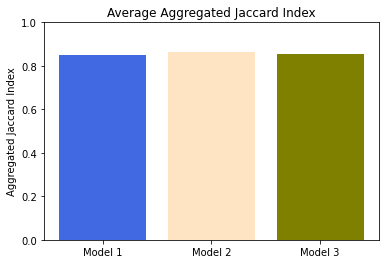

In [145]:
# Compare the average aggregated jaccard index between models in a bar plot
display_average_aji_comparison(model_results)